In [244]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import sparse
import requests
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import Normalizer
import re
from IPython.display import display
from scipy.sparse.linalg import svds

### 0.1 - Load and Prepare Data

In [245]:
# Load df_books and genres
wd = os.getcwd()
df_books = pd.read_csv(wd + "/data/goodreads_books.csv")
df_inferred_genres = pd.read_csv(wd + "/data/inferred_genres.csv")
genre_descriptors = pd.read_csv(wd + "/data/inferred_genre_top_words.csv")

# Join genres to books
df_books = pd.merge(df_books, df_inferred_genres.drop(columns="title"), how="left", on="book_id")

In [246]:
# Load sparse_reviews from file
df_reviews = sparse.load_npz(wd + "/data/user_reviews.npz")

# Load user (rows) and book (cols) indices
user_index = pd.read_csv(wd + "/data/user_index_for_sparse_matrix.csv").rename(columns={"0":"user_id"})
book_index = pd.read_csv(wd + "/data/book_index_for_sparse_matrix.csv").rename(columns={"0":"book_id"})

In [247]:
# Load my goodreads history
my_books = pd.read_csv(wd + "/data/goodreads_library_export.csv")

# Filter to books I've rated
my_books = my_books[["Book Id", "My Rating"]].rename(columns={"Book Id":"book_id", "My Rating":"rating"}).query("rating > 0")

# Reformat to fit sparse matrix
my_books = pd.merge(book_index, my_books, how="left", on="book_id").fillna(0.)
my_books = np.array(my_books["rating"]).reshape(1,-1)

# Add to sparse matrix
df_reviews = sparse.vstack([df_reviews, my_books])

# Replace 0 with 0.000001 to prevent cosine similarities from zeroing
sparse_fill = 0.000001
df_reviews.data[df_reviews.data == 0] = sparse_fill

# Normalize reviews within users
norm = Normalizer()
df_reviews = norm.fit_transform(df_reviews) 

### 1.1 - User:User Collaborative Filtering with KNN

In [248]:
target = df_reviews.shape[0] - 1

In [249]:
# Function to use KNN to find similar users
def find_neighbors(n_neighbors, target_user, ratings_df, ind_books, books):

    # Instantiate KNN
    n_neighbors = n_neighbors

    nn_model = NearestNeighbors(
        metric="cosine",
        algorithm="auto",
        n_neighbors=n_neighbors,
        n_jobs=-1
    )

    # Fit to sparse matrix
    nn_model.fit(ratings_df)

    # Feed in user and get neighbors and distances
    reader = ratings_df[target,:].toarray()
    dists, neighbors = nn_model.kneighbors(reader, return_distance=True)

    similar_users = pd.DataFrame(
        [pd.Series(neighbors.reshape(-1)), pd.Series(dists.reshape(-1))]).T.rename(columns={0:"user", 1:"distance"}
    )

    # Get all books read by similar users
    book_ind = []
    book_rat = []
    uid = []
    target_user_books = []
    target_user_book_rat = []
    for nt in similar_users.itertuples():
        user = ratings_df[int(nt.user),:].toarray()
        book_inds = np.where(user[0] > 0)[0]
        ratings = user[0][np.where(user[0] > 0)[0]]
        for i in range(len(book_inds)):        
            book_ind.append(book_inds[i])
            book_rat.append(ratings[i])
            uid.append(nt.user)    
            if nt.distance < 0.000000001:
                target_user_books.append(book_inds[i])
                target_user_book_rat.append(ratings[i])

    neighbor_user_ratings = pd.DataFrame([uid, book_ind, book_rat]).T.rename(columns={0:"uid",1:"book_index",2:"user_rating"})

    # Join overall rating for each book
    neighbor_user_ratings = pd.merge(ind_books.reset_index(), neighbor_user_ratings, how="inner", left_on="index", right_on="book_index")
    neighbor_user_ratings = pd.merge(neighbor_user_ratings, books, how="inner", on="book_id")

    # Filter out books target reader has already read
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["book_index"].isin(target_user_books)]
    neighbor_user_ratings.drop(["index"], axis=1, inplace=True)

    # Filter out later volumes in series using regex pattern
    regex1 = r"#([3-9]|[1-9]\d+)"
    regex2 = r"Vol. ([0-9]|[1-9]\d+)"
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex1)]
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex2)]
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains("#1-")]

    # View target user's ratings
    target_user_ratings = pd.DataFrame([target_user_books, target_user_book_rat]).T.rename(columns={0:"book_index",1:"user_rating"})
    target_user_ratings = pd.merge(ind_books.reset_index(), target_user_ratings, how="inner", left_on="index", right_on="book_index")
    target_user_ratings = pd.merge(target_user_ratings, books, how="inner", on="book_id")    

    return neighbor_user_ratings, target_user_ratings

In [250]:
n_neighbors = 75
neighbor_user_ratings, target_user_ratings = find_neighbors(n_neighbors, target, df_reviews, book_index, df_books)

/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_3762/2867291065.py:56: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex1)]
/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_3762/2867291065.py:57: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex2)]


In [251]:
# View neighbors rating table
neighbor_user_ratings.head()

,book_id,uid,book_index,user_rating,title,avg_rating,ratings_count,year,language_code,image_url,...,Genre_16,Genre_17,Genre_18,Genre_19,Genre_20,Genre_21,Genre_22,Genre_23,Genre_24,Genre_25
0,100915,83359.0,5497.0,0.267860,"The Lion, the Witch, and the Wardrobe (Chronic...",4.19,1575387.0,2005,eng,https://images.gr-assets.com/books/1353029077m...,...,0.007298,0.007298,0.007298,0.007298,0.007298,0.007298,0.007298,0.007298,0.007298,0.007298
1,10127019,149314.0,8108.0,0.114992,The Lean Startup: How Today's Entrepreneurs Us...,4.04,95622.0,2011,en-US,https://images.gr-assets.com/books/1333576876m...,...,0.005015,0.005015,0.005015,0.005015,0.005015,0.005015,0.005015,0.005015,0.005015,0.005015
2,10193060,122168.0,13183.0,0.248452,Miserere: An Autumn Tale,3.79,747.0,2011,eng,https://images.gr-assets.com/books/1301084223m...,...,0.006133,0.006133,0.006133,0.006133,0.006133,0.006133,0.852806,0.006133,0.006133,0.006133
3,10245518,133863.0,17082.0,0.158986,The Checklist Manifesto How to Get Things Right,4.03,268.0,2011,eng,https://images.gr-assets.com/books/1356488549m...,...,0.004696,0.004696,0.004696,0.004696,0.004696,0.004696,0.004696,0.004696,0.004696,0.004696
4,10321016,204297.0,22603.0,0.368230,Pitch Anything: An Innovative Method for Prese...,4.09,4346.0,2011,NaN,https://s.gr-assets.com/assets/nophoto/book/11...,...,0.005604,0.005604,0.005604,0.005604,0.005604,0.005604,0.005604,0.005604,0.005604,0.005604


### 1.2 - Generate Recommendations from Similar Readers

In [252]:
# 20 most popular books among similar readers
popular_recs = neighbor_user_ratings.groupby(["title", "avg_rating", "ratings_count", "year"])["book_id"]\
    .count().reset_index().sort_values(by=["book_id", "avg_rating"], ascending=False)\
    .nlargest(20, "book_id").rename(columns={"book_id":"percent_similar_users_read"})

popular_recs["percent_similar_users_read"] = (popular_recs["percent_similar_users_read"] / n_neighbors).map('{:.1%}'.format)

popular_recs

,title,avg_rating,ratings_count,year,percent_similar_users_read
43,"Caliban's War (The Expanse, #2)",4.29,41459.0,2012,9.3%
3,"A Clash of Kings (A Song of Ice and Fire, #2)",4.40,534960.0,2002,8.0%
245,The Gunslinger,3.98,346978.0,1982,5.3%
199,"Surely You're Joking, Mr. Feynman!: Adventures...",4.29,95353.0,1997,4.0%
141,Ninefox Gambit (The Machineries of Empire #1),3.91,3425.0,2016,4.0%
111,Judas Unchained,4.30,21306.0,2005,2.7%
15,"Age of Myth (The Legends of the First Empire, #1)",4.27,9328.0,2016,2.7%
330,"Wool Omnibus (Silo, #1)",4.24,83601.0,2012,2.7%
310,"To Say Nothing of the Dog (Oxford Time Travel,...",4.13,23617.0,1998,2.7%
239,The Golem and the Jinni (The Golem and the Jin...,4.10,61387.0,2013,2.7%


In [253]:
# 10 highest rated books among similar readers
highest_rated_recs = neighbor_user_ratings.groupby(["title", "avg_rating", "ratings_count", "year"])["book_id"]\
    .count().reset_index().sort_values(by=["avg_rating", "book_id"], ascending=False)\
    .nlargest(20, "avg_rating").rename(columns={"book_id":"percent_similar_users_read"})

highest_rated_recs["percent_similar_users_read"] = (highest_rated_recs["percent_similar_users_read"] / n_neighbors).map('{:.1%}'.format)
highest_rated_recs

,title,avg_rating,ratings_count,year,percent_similar_users_read
291,The Story of Human Language,4.44,394.0,2004,1.3%
301,"The Walking Dead, Compendium 1",4.43,58434.0,2009,1.3%
114,"Kings of the Wyld (The Band, #1)",4.42,2285.0,2017,1.3%
12,Adventure Time With Fionna and Cake,4.41,2542.0,2013,1.3%
3,"A Clash of Kings (A Song of Ice and Fire, #2)",4.40,534960.0,2002,8.0%
58,David Attenborough's Life on Air: Memoirs of a...,4.39,1836.0,2003,1.3%
264,The Looming Tower: Al-Qaeda and the Road to 9/11,4.38,13019.0,2006,1.3%
94,Homicide: A Year on the Killing Streets,4.37,10487.0,1991,1.3%
176,"Senlin Ascends (The Books of Babel, #1)",4.37,1410.0,2013,1.3%
313,"Traitor to the Throne (Rebel of the Sands, #2)",4.35,4825.0,2017,1.3%


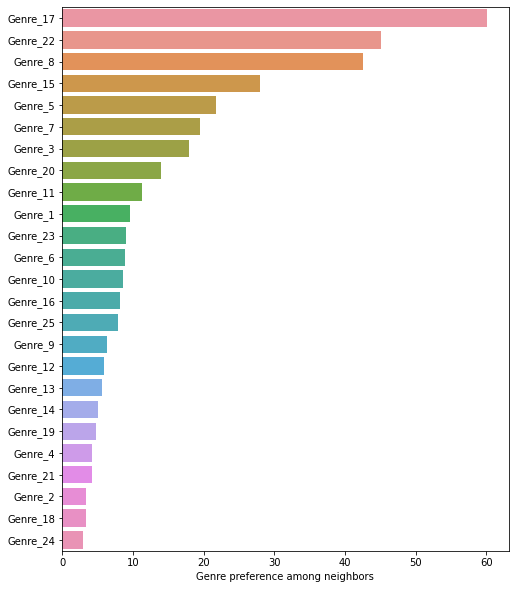

In [254]:
# Plot target reader's top genres
fig, ax = plt.subplots(figsize=(8,10))
genre_ranking = pd.DataFrame(neighbor_user_ratings.loc[:, "Genre_1":].sum(axis=0).sort_values(ascending=False))
sns.barplot(
    data=genre_ranking,
    y=genre_ranking.index,
    x=0
)
plt.xlabel("Genre preference among neighbors")
plt.show()

In [255]:
# Loop through genres in descending relevance order and print top recs
for genre in genre_ranking.index[0:5]:
    
    g = float(genre[6:])
    highest_rated_recs_genre = neighbor_user_ratings.query("main_genre == @g")\
        .groupby(["title", "avg_rating", "ratings_count", "year", "url"])["book_id"]\
        .count().reset_index().sort_values(by=["avg_rating", "book_id"], ascending=False)\
        .rename(columns={"book_id":"percent_similar_users_read"})

    highest_rated_recs_genre["percent_similar_users_read"] = highest_rated_recs_genre["percent_similar_users_read"] / n_neighbors
    highest_rated_recs_genre = highest_rated_recs_genre.query("ratings_count > 400 & avg_rating > 3.9")

    # Print genre name and descriptor
    for nt in genre_descriptors.itertuples():
        genre_rep = genre.replace("_"," ")
        if nt.genre_string[0:len(f"{genre}:")] == f"{genre_rep}:":
            print(nt.genre_string)
            
    display(highest_rated_recs_genre[["title", "avg_rating", "ratings_count", "url"]].head(10))
    print("_____\n")

Genre 17: ['alien', 'planet', 'world', 'human', 'ship', 'space', 'war', 'crew', 'mission', 'race']


,title,avg_rating,ratings_count,url
58,"The Walking Dead, Compendium 1",4.43,58434.0,https://www.goodreads.com/book/show/6465707-th...
20,"Kings of the Wyld (The Band, #1)",4.42,2285.0,https://www.goodreads.com/book/show/30841984-k...
19,Judas Unchained,4.30,21306.0,https://www.goodreads.com/book/show/45244.Juda...
5,"Caliban's War (The Expanse, #2)",4.29,41459.0,https://www.goodreads.com/book/show/12591698-c...
22,Lost Stars,4.25,9512.0,https://www.goodreads.com/book/show/25067046-l...
30,Pandora's Star,4.24,28964.0,https://www.goodreads.com/book/show/45252.Pand...
32,"Raven Stratagem (The Machineries of Empire, #2)",4.23,945.0,https://www.goodreads.com/book/show/30691976-r...
61,War Factory (Transformation #2),4.23,909.0,https://www.goodreads.com/book/show/25898503-w...
51,"The Honor of the Queen (Honor Harrington, #2)",4.21,487.0,https://www.goodreads.com/book/show/261758.The...
47,The Dreaming Void,4.18,16512.0,https://www.goodreads.com/book/show/866136.The...


_____

Genre 22: ['world', 'power', 'enemy', 'war', 'battle', 'evil', 'magic', 'save', 'ancient', 'warrior']


,title,avg_rating,ratings_count,url
0,"A Clash of Kings (A Song of Ice and Fire, #2)",4.40,534960.0,https://www.goodreads.com/book/show/10572.A_Cl...
44,"Traitor to the Throne (Rebel of the Sands, #2)",4.35,4825.0,https://www.goodreads.com/book/show/29739361-t...
16,Michael Moorcock's Elric of Melnibone,4.32,1137.0,https://www.goodreads.com/book/show/8658529-mi...
42,"Thrawn (Star Wars: Thrawn, #1)",4.30,5220.0,https://www.goodreads.com/book/show/31140332-t...
2,"Age of Myth (The Legends of the First Empire, #1)",4.27,9328.0,https://www.goodreads.com/book/show/26863057-a...
13,"Lion of Macedon (Greek Series, #1)",4.24,3375.0,https://www.goodreads.com/book/show/257054.Lio...
30,The False Prince (The Ascendance Trilogy #1),4.23,51292.0,https://www.goodreads.com/book/show/12432220-t...
24,"Rogue Wave (Waterfire Saga, #2)",4.22,4566.0,https://www.goodreads.com/book/show/20646683-r...
15,Lost Boy: The True Story of Captain Hook,4.20,1420.0,https://www.goodreads.com/book/show/32828538-l...
20,"Paladin of Souls (World of the Five Gods, #2)",4.13,16197.0,https://www.goodreads.com/book/show/61904.Pala...


_____

Genre 8: ['guide', 'people', 'way', 'help', 'practical', 'world', 'experience', 'offer', 'question', 'business']


,title,avg_rating,ratings_count,url
6,"Creativity, Inc.: Overcoming the Unseen Forces...",4.24,27705.0,https://www.goodreads.com/book/show/18077903-c...
11,"Don't Make Me Think, Revisited: A Common Sense...",4.24,4444.0,https://www.goodreads.com/book/show/18197267-d...
12,Falling Upward: A Spirituality for the Two Hal...,4.24,4884.0,https://www.goodreads.com/book/show/9963483-fa...
2,Becoming Wise: An Inquiry into the Mystery and...,4.22,1683.0,https://www.goodreads.com/book/show/25894085-b...
10,"Desiring the Kingdom: Worship, Worldview, and ...",4.22,1659.0,https://www.goodreads.com/book/show/5944774-de...
4,"Boundaries: When to Say Yes, How to Say No to ...",4.19,13041.0,https://www.goodreads.com/book/show/944267.Bou...
9,Deep Work: Rules for Focused Success in a Dist...,4.19,15605.0,https://www.goodreads.com/book/show/25744928-d...
1,"After the Ecstasy, the Laundry: How the Heart ...",4.16,3187.0,https://www.goodreads.com/book/show/341631.Aft...
41,"The Vital Question: Energy, Evolution, and the...",4.14,843.0,https://www.goodreads.com/book/show/23316494-t...
24,Superforecasting: The Art and Science of Predi...,4.13,4876.0,https://www.goodreads.com/book/show/23995360-s...


_____

Genre 15: ['history', 'poem', 'essay', 'text', 'century', 'collection', 'world', 'writing', 'introduction', 'literature']


,title,avg_rating,ratings_count,url
17,The Circular Ruins,4.30,409.0,https://www.goodreads.com/book/show/28110198-t...
12,"Surely You're Joking, Mr. Feynman!: Adventures...",4.29,95353.0,https://www.goodreads.com/book/show/5544.Surel...
27,The World of Ice & Fire: The Untold History of...,4.26,12952.0,https://www.goodreads.com/book/show/17345242-t...
0,Atlas of Remote Islands,4.24,1807.0,https://www.goodreads.com/book/show/8197735-at...
18,The Hero With a Thousand Faces,4.24,18378.0,https://www.goodreads.com/book/show/588138.The...
25,The Truth: An Uncomfortable Book About Relatio...,4.20,2503.0,https://www.goodreads.com/book/show/26887738-t...
14,The 50th Law,4.13,4254.0,https://www.goodreads.com/book/show/6043946-th...
21,The Story of B: An Adventure of the Mind and S...,4.11,7822.0,https://www.goodreads.com/book/show/214579.The...
28,Thousandth Night,4.10,434.0,https://www.goodreads.com/book/show/18129561-t...
20,The Rest Is Noise: Listening to the Twentieth ...,4.08,9607.0,https://www.goodreads.com/book/show/392563.The...


_____

Genre 5: ['history', 'war', 'political', 'account', 'world', 'year', 'country', 'family', 'century', 'people']


,title,avg_rating,ratings_count,url
12,Our Revolution: A Future to Believe In,4.29,2430.0,https://www.goodreads.com/book/show/31741420-o...
10,"Killer of Men (Long War, #1)",4.27,1176.0,https://www.goodreads.com/book/show/7998933-ki...
11,Man-Eaters of Kumaon,4.25,2609.0,https://www.goodreads.com/book/show/475245.Man...
3,An Era of Darkness: The British Empire in India,4.23,875.0,https://www.goodreads.com/book/show/32618967-a...
7,Forward the Foundation (Foundation: Prequel #2),4.13,32394.0,https://www.goodreads.com/book/show/76679.Forw...
21,"Working Stiff: Two Years, 262 Bodies, and the ...",4.11,8101.0,https://www.goodreads.com/book/show/18775327-w...
17,The New Tsar: The Rise and Reign of Vladimir P...,4.09,1379.0,https://www.goodreads.com/book/show/24040192-t...
5,Dawn (Legend of the Galactic Heroes #1),4.06,418.0,https://www.goodreads.com/book/show/25986983-dawn
9,If the Oceans Were Ink: An Unlikely Friendship...,4.02,792.0,https://www.goodreads.com/book/show/22320455-i...
13,Pastwatch: The Redemption of Christopher Columbus,3.96,12053.0,https://www.goodreads.com/book/show/40293.Past...


_____



### 2.1 - User:Item Collaborative Filtering with Matrix Factorization

In [256]:
# Find larger number of similar users than before to get broad pool of potentially relevant books
large_neighborhood_ratings, target_user_ratings = find_neighbors(1500, target, df_reviews, book_index, df_books)

/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_3762/2867291065.py:56: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex1)]
/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_3762/2867291065.py:57: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex2)]


In [257]:
# Get unique users and books to slice df_reviews
neighbor_index = large_neighborhood_ratings["uid"].unique()
neighbor_index = np.append(neighbor_index, target)
neighbor_book_index = large_neighborhood_ratings["book_index"].unique()
neighbor_book_index = np.append(neighbor_book_index, target_user_ratings["book_index"].unique())

# Slice df_reviews to make User Ratings Matrix
R = df_reviews[:, neighbor_book_index]
R = R[neighbor_index, :]

In [270]:
# Decompose user ratings matrix R
U, sigma, Vt = svds(R, k = 5)
sigma = np.diag(sigma)

U = sparse.csr_matrix(U)
sigma = sparse.csr_matrix(sigma)
Vt = sparse.csr_matrix(Vt)

### 2.2 - Generating Recommendations by Making Rating Predictions from Matrix Factorization

In [271]:
# Get predictions
all_user_predicted_ratings = U.dot(sigma) @ Vt
df_preds = pd.DataFrame(all_user_predicted_ratings.toarray(), columns=neighbor_book_index, index=neighbor_index).reset_index()

In [272]:
# Get target user's top predicted ratings
target_pred_books = df_preds[df_preds["index"] == target].columns[1:]
target_pred_ratings = df_preds[df_preds["index"] == target].values[0][1:]

# Put into df with relevant info from df_books
top_preds = pd.DataFrame({"book_index":target_pred_books, "predicted_rating":target_pred_ratings})\
                .sort_values(by="predicted_rating", ascending=False)\
                .merge(book_index.reset_index(), left_on="book_index", right_on="index")\
                .merge(df_books[["book_id", "title", "avg_rating", "ratings_count", "year", "main_genre","url"]], on="book_id")\
                .drop(columns=["index", "book_id"])

# Filter out already read books
top_preds = top_preds[~top_preds["book_index"].isin(target_user_ratings["book_index"].unique())]
top_preds.drop(["book_index"], axis=1, inplace=True)
top_preds.head(10)

,predicted_rating,title,avg_rating,ratings_count,year,main_genre,url
5,0.018129,The Slow Regard of Silent Things (The Kingkill...,3.91,60529.0,2014,25.0,https://www.goodreads.com/book/show/21535271-t...
6,0.017022,"Caliban's War (The Expanse, #2)",4.29,41459.0,2012,17.0,https://www.goodreads.com/book/show/12591698-c...
7,0.016678,The Hundred Thousand Kingdoms (Inheritance Tri...,3.81,30194.0,2010,22.0,https://www.goodreads.com/book/show/6437061-th...
8,0.013261,Ninefox Gambit (The Machineries of Empire #1),3.91,3425.0,2016,22.0,https://www.goodreads.com/book/show/26118426-n...
9,0.013156,The Magicians (The Magicians #1),3.48,152315.0,2009,7.0,https://www.goodreads.com/book/show/6101718-th...
10,0.013120,Freakonomics: A Rogue Economist Explores the H...,3.94,529274.0,2006,8.0,https://www.goodreads.com/book/show/1202.Freak...
11,0.010845,"I, Robot (Robot #0.1)",4.17,201196.0,2004,17.0,https://www.goodreads.com/book/show/41804.I_Robot
12,0.009573,The Gunslinger,3.98,346978.0,1982,3.0,https://www.goodreads.com/book/show/43615.The_...
13,0.009440,"Wool Omnibus (Silo, #1)",4.24,83601.0,2012,2.0,https://www.goodreads.com/book/show/13453029-w...
14,0.009409,The Golem and the Jinni (The Golem and the Jin...,4.10,61387.0,2013,7.0,https://www.goodreads.com/book/show/15819028-t...


In [274]:
# Loop through genres in descending relevance order and print top recs
for genre in genre_ranking.index[0:10]:
    
    g = float(genre[6:])
    highest_rated_pred_genre = top_preds.query("main_genre == @g")\
        .sort_values(by="predicted_rating", ascending=False)\
        .query("ratings_count > 400 & avg_rating >= 4.15")\

    # Print genre name and descriptor
    for nt in genre_descriptors.itertuples():
        genre_rep = genre.replace("_"," ")
        if nt.genre_string[0:len(f"{genre}:")] == f"{genre_rep}:":
            print(nt.genre_string)
    
    display(highest_rated_pred_genre[["title", "avg_rating", "ratings_count","url"]].iloc[0:20,:])
    print("_____\n")

Genre 17: ['alien', 'planet', 'world', 'human', 'ship', 'space', 'war', 'crew', 'mission', 'race']


,title,avg_rating,ratings_count,url
6,"Caliban's War (The Expanse, #2)",4.29,41459.0,https://www.goodreads.com/book/show/12591698-c...
11,"I, Robot (Robot #0.1)",4.17,201196.0,https://www.goodreads.com/book/show/41804.I_Robot
41,Judas Unchained,4.30,21306.0,https://www.goodreads.com/book/show/45244.Juda...
47,Pandora's Star,4.24,28964.0,https://www.goodreads.com/book/show/45252.Pand...
72,"Raven Stratagem (The Machineries of Empire, #2)",4.23,945.0,https://www.goodreads.com/book/show/30691976-r...
97,"Kings of the Wyld (The Band, #1)",4.42,2285.0,https://www.goodreads.com/book/show/30841984-k...
106,Lost Stars,4.25,9512.0,https://www.goodreads.com/book/show/25067046-l...
162,The Dreaming Void,4.18,16512.0,https://www.goodreads.com/book/show/866136.The...
163,"The Scar (Bas-Lag, #2)",4.15,21122.0,https://www.goodreads.com/book/show/68497.The_...
186,"Adulthood Rites (Xenogenesis, #2)",4.16,7081.0,https://www.goodreads.com/book/show/116249.Adu...


_____

Genre 22: ['world', 'power', 'enemy', 'war', 'battle', 'evil', 'magic', 'save', 'ancient', 'warrior']


,title,avg_rating,ratings_count,url
37,"Age of Myth (The Legends of the First Empire, #1)",4.27,9328.0,https://www.goodreads.com/book/show/26863057-a...
78,"Traitor to the Throne (Rebel of the Sands, #2)",4.35,4825.0,https://www.goodreads.com/book/show/29739361-t...
90,"Red Sister (Book of the Ancestor, #1)",4.32,5784.0,https://www.goodreads.com/book/show/25895524-r...
115,"Thrawn (Star Wars: Thrawn, #1)",4.30,5220.0,https://www.goodreads.com/book/show/31140332-t...
131,"The Wall of Storms (The Dandelion Dynasty, #2)",4.33,1078.0,https://www.goodreads.com/book/show/18952381-t...
197,"Promise of Blood (Powder Mage, #1)",4.16,22179.0,https://www.goodreads.com/book/show/15790883-p...
222,"The Crimson Campaign (Powder Mage, #2)",4.35,15125.0,https://www.goodreads.com/book/show/17608111-t...
227,When Christ and His Saints Slept (Henry II an...,4.27,10892.0,https://www.goodreads.com/book/show/43841.When...
257,Rogue One: A Star Wars Story,4.17,3228.0,https://www.goodreads.com/book/show/30008713-r...
275,"Split the Party (Spells, Swords, & Stealth, #2)",4.25,2062.0,https://www.goodreads.com/book/show/25920141-s...


_____

Genre 8: ['guide', 'people', 'way', 'help', 'practical', 'world', 'experience', 'offer', 'question', 'business']


,title,avg_rating,ratings_count,url
102,If Grace Is True: Why God Will Save Every Pers...,4.20,956.0,https://www.goodreads.com/book/show/111829.If_...
141,Continuous Delivery: Reliable Software Release...,4.15,1748.0,https://www.goodreads.com/book/show/8686650-co...
239,"Creativity, Inc.: Overcoming the Unseen Forces...",4.24,27705.0,https://www.goodreads.com/book/show/18077903-c...
240,Doing Good Better: How Effective Altruism Can ...,4.23,1265.0,https://www.goodreads.com/book/show/23398748-d...
249,Deep Work: Rules for Focused Success in a Dist...,4.19,15605.0,https://www.goodreads.com/book/show/25744928-d...
293,The (7L) The Seven Levels of Communication: Go...,4.33,482.0,https://www.goodreads.com/book/show/9858250-th...
301,JavaScript: The Good Parts,4.23,5716.0,https://www.goodreads.com/book/show/2998152-ja...
316,"""I Give You My Body . . ."": How I Write Sex Sc...",4.21,481.0,https://www.goodreads.com/book/show/30719827-i...
328,Linear Algebra Done Right,4.26,448.0,https://www.goodreads.com/book/show/309768.Lin...
377,The Hard Thing About Hard Things: Building a B...,4.20,20745.0,https://www.goodreads.com/book/show/18176747-t...


_____

Genre 15: ['history', 'poem', 'essay', 'text', 'century', 'collection', 'world', 'writing', 'introduction', 'literature']


,title,avg_rating,ratings_count,url
42,Guns,4.17,3687.0,https://www.goodreads.com/book/show/17284577-guns
113,Cosmicomics,4.20,10568.0,https://www.goodreads.com/book/show/59780.Cosm...
120,Feminism is for Everybody: Passionate Politics,4.18,7740.0,https://www.goodreads.com/book/show/168484.Fem...
160,The World of Ice & Fire: The Untold History of...,4.26,12952.0,https://www.goodreads.com/book/show/17345242-t...
173,"Surely You're Joking, Mr. Feynman!: Adventures...",4.29,95353.0,https://www.goodreads.com/book/show/5544.Surel...
190,Sixth of the Dusk,4.21,8122.0,https://www.goodreads.com/book/show/23397921-s...
196,"Short Stories from Hogwarts of Heroism, Hardsh...",4.23,16961.0,https://www.goodreads.com/book/show/31538635-s...
205,The Laugh of the Medusa,4.16,752.0,https://www.goodreads.com/book/show/11080013-t...
466,The Invention of Nature: Alexander von Humbold...,4.29,4817.0,https://www.goodreads.com/book/show/23995249-t...
474,Srikanta,4.23,1004.0,https://www.goodreads.com/book/show/1417962.Sr...


_____

Genre 5: ['history', 'war', 'political', 'account', 'world', 'year', 'country', 'family', 'century', 'people']


,title,avg_rating,ratings_count,url
80,"American Tabloid (Underworld USA, #1)",4.21,10342.0,https://www.goodreads.com/book/show/36064.Amer...
86,Shoe Dog: A Memoir by the Creator of NIKE,4.44,27468.0,https://www.goodreads.com/book/show/27220736-s...
89,"March: Book One (March, #1)",4.34,21092.0,https://www.goodreads.com/book/show/17346698-m...
155,The Forgotten Soldier,4.36,6108.0,https://www.goodreads.com/book/show/102305.The...
176,Dancing in the Glory of Monsters: The Collapse...,4.15,2391.0,https://www.goodreads.com/book/show/10046142-d...
180,"The Prize: The Epic Quest for Oil, Money, and ...",4.40,5329.0,https://www.goodreads.com/book/show/169354.The...
184,The Silk Roads: A New History of the World,4.25,3022.0,https://www.goodreads.com/book/show/25812847-t...
211,Pachinko,4.18,8161.0,https://www.goodreads.com/book/show/29983711-p...
236,Journalism,4.21,829.0,https://www.goodreads.com/book/show/12160809-j...
238,In Order to Live: A North Korean Girl's Journe...,4.48,8076.0,https://www.goodreads.com/book/show/24611623-i...


_____

Genre 7: ['fairy', 'magic', 'adventure', 'world', 'magical', 'die', 'fantasy', 'journey', 'young', 'land']


,title,avg_rating,ratings_count,url
138,Bridge of Birds (The Chronicles of Master Li a...,4.30,8063.0,https://www.goodreads.com/book/show/15177.Brid...
252,The Wind Through the Keyhole,4.15,37166.0,https://www.goodreads.com/book/show/12341557-t...
269,"The Pillars of the Earth (Kingsbridge, #1)",4.29,471990.0,https://www.goodreads.com/book/show/5043.The_P...
715,"The Lion, the Witch, and the Wardrobe (Chronic...",4.19,1575387.0,https://www.goodreads.com/book/show/100915.The...
755,"Penric's Demon (Penric and Desdemona, #1)",4.21,3391.0,https://www.goodreads.com/book/show/25791216-p...
841,"The 13½ Lives of Captain Bluebear (Zamonia, #1)",4.20,10790.0,https://www.goodreads.com/book/show/62032.The_...
851,The Light Princess and Other Fairy Stories,4.17,489.0,https://www.goodreads.com/book/show/179576.The...
883,"The Eyes of the Overworld (The Dying Earth, #2)",4.16,2483.0,https://www.goodreads.com/book/show/872816.The...
941,Interstellar Cinderella,4.22,2024.0,https://www.goodreads.com/book/show/22875394-i...
1064,Jaya: An Illustrated Retelling of the Mahabharata,4.20,9857.0,https://www.goodreads.com/book/show/9864913-jaya


_____

Genre 3: ['collection', 'comic', 'short', 'fan', 'feature', 'bestselling', 'adventure', 'available', 'classic', 'includes']


,title,avg_rating,ratings_count,url
58,Y: The Last Man - The Deluxe Edition Book One,4.36,10549.0,https://www.goodreads.com/book/show/3710603-y
171,A Good Man is Hard to Find and Other Stories,4.24,26384.0,https://www.goodreads.com/book/show/48464.A_Go...
221,The Kite Runner: Graphic Novel,4.25,6466.0,https://www.goodreads.com/book/show/11296523-t...
485,The Dark Tower,4.27,96576.0,https://www.goodreads.com/book/show/5091.The_D...
501,The Private Eye,4.24,1847.0,https://www.goodreads.com/book/show/26247784-t...
621,Adventure Time With Fionna and Cake,4.41,2542.0,https://www.goodreads.com/book/show/17348705-a...
986,"The Hedge Knight (The Tales of Dunk and Egg, #1)",4.23,14640.0,https://www.goodreads.com/book/show/11970747-t...
1031,"Batman: Earth One, Volume 2",4.22,2332.0,https://www.goodreads.com/book/show/23012543-b...
1085,Nightfall and Other Stories,4.27,10420.0,https://www.goodreads.com/book/show/70771.Nigh...
1094,"Hawkeye, Volume 2: Little Hits",4.26,16304.0,https://www.goodreads.com/book/show/17277800-h...


_____

Genre 20: ['family', 'year', 'child', 'young', 'home', 'past', 'world', 'loss', 'secret', 'friend']


,title,avg_rating,ratings_count,url
17,All But My Life: A Memoir,4.28,14073.0,https://www.goodreads.com/book/show/163363.All...
36,Daytripper,4.31,18265.0,https://www.goodreads.com/book/show/8477057-da...
38,Night (The Night Trilogy #1),4.30,708754.0,https://www.goodreads.com/book/show/1617.Night
118,The Woman on the Orient Express,4.15,2305.0,https://www.goodreads.com/book/show/29806077-t...
133,The Story of a New Name (The Neapolitan Novels...,4.36,36545.0,https://www.goodreads.com/book/show/17465515-t...
262,My Journey : Transforming Dreams into Actions,4.35,1743.0,https://www.goodreads.com/book/show/18371021-m...
263,Hum If You Don’t Know the Words,4.22,971.0,https://www.goodreads.com/book/show/28264701-h...
351,The Best We Could Do,4.39,2485.0,https://www.goodreads.com/book/show/29936927-t...
353,"Redefining Realness: My Path to Womanhood, Ide...",4.30,4581.0,https://www.goodreads.com/book/show/18144031-r...
486,You Don't Have to Say You Love Me,4.36,4478.0,https://www.goodreads.com/book/show/31420708-y...


_____

Genre 11: ['fiction', 'collection', 'world', 'literary', 'young', 'funny', 'short', 'comedy', 'horror', 'debut']


,title,avg_rating,ratings_count,url
246,The Refrigerator Monologues,4.21,894.0,https://www.goodreads.com/book/show/32714267-t...
338,Love's Executioner and Other Tales of Psychoth...,4.18,14376.0,https://www.goodreads.com/book/show/21027.Love...
2140,"Ava's Demon: Book One (Ava's Demon, #1)",4.46,669.0,https://www.goodreads.com/book/show/18043803-a...
2169,Deathbird Stories,4.20,2836.0,https://www.goodreads.com/book/show/219376.Dea...
2284,The Dot and the Line: A Romance in Lower Mathe...,4.35,1197.0,https://www.goodreads.com/book/show/289866.The...
2301,A Manual for Cleaning Women: Selected Stories,4.17,6863.0,https://www.goodreads.com/book/show/22929586-a...
2558,Arrival,4.27,447.0,https://www.goodreads.com/book/show/31625351-a...
2814,Animal Farm / 1984,4.26,120269.0,https://www.goodreads.com/book/show/5472.Anima...
3119,Asterios Polyp,4.19,20053.0,https://www.goodreads.com/book/show/4070095-as...
3324,In the Garden of the North American Martyrs,4.15,1706.0,https://www.goodreads.com/book/show/54510.In_t...


_____

Genre 1: ['family', 'young', 'house', 'home', 'island', 'village', 'secret', 'world', 'old', 'beautiful']


,title,avg_rating,ratings_count,url
305,"Come, Tell Me How You Live",4.16,1735.0,https://www.goodreads.com/book/show/111516.Com...
393,The Alice Network,4.27,13055.0,https://www.goodreads.com/book/show/32051912-t...
523,Fool's Assassin (The Fitz and The Fool Trilogy...,4.36,5382.0,https://www.goodreads.com/book/show/18658063-f...
534,Jayber Crow,4.34,6720.0,https://www.goodreads.com/book/show/57460.Jayb...
909,"Fool's Assassin (The Fitz and the Fool, #1)",4.36,16677.0,https://www.goodreads.com/book/show/19288321-f...
1084,From the Holy Mountain: A Journey Among the Ch...,4.28,2038.0,https://www.goodreads.com/book/show/104039.Fro...
1312,"Dragonsong (Harper Hall, #1)",4.24,36174.0,https://www.goodreads.com/book/show/28541.Drag...
1366,The Borders of Infinity,4.24,3645.0,https://www.goodreads.com/book/show/5073782-th...
1541,"My Family and Other Animals (Corfu Trilogy, #1)",4.26,20655.0,https://www.goodreads.com/book/show/48132.My_F...
1754,Beetle in the Anthill,4.23,1032.0,https://www.goodreads.com/book/show/759514.Bee...


_____

